# PROJECT: INVESTIGATE OLIST ECOMMERCE DATASET 9/2016 - 9/2018

### SLIDE POWERPOINT : [LINK HERE](https://docs.google.com/presentation/d/1qf4kYw4chKJosIFt5YRy63_6xPeJGzHk/edit?usp=sharing&ouid=113590250673083599363&rtpof=true&sd=true)

### Table Of Contents
*   Introduction
*   Objective
*   Questions
*   Data Wrangling
*   Data Analysis & Exploratory Data Analysis
*   Conclusions

## Introduction


> This project contains 100,000+ rows representing orders on Olist platform between 9/2016 - 9/2018 from 9 differents datasets. The dataset includes customer, seller,  orders, payments, products, categories, and geolocation data. Olist dataset is one of the most chosen datasets on Kaggle, and one of the rarest datasets belonged to an eCommerce that we could find. Let's see if we can find different insights from others.

##Objective



> The most challenging thing about doing this project olist is the uncountable amount of analysis everywhere from other people. I am afraid that I will not be able to figure out what is different from everyone else, and it is pretty hard to avoid what everyone has already analyzed. But on the other sides, I feel excited about the challenge and spend more hours checking if people missed any aspects. Eventually, I found that no one has pointed out the surprisingly low number of return customers, which is considered the vital metric of any eCommerce. At that moment, I knew I had to explore the story behind the low metric.



## Questions: HOW TO WIN OUR CUSTOMERS BACK?



**DATA PROCESSING**

In [ ]:
#Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
import nltk
import numpy as np
import sqlite3
import datetime
import re

In [ ]:
#Import, read data
items = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_order_items_dataset.csv')
payments = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_order_payments_dataset.csv')
reviews = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_order_reviews_dataset.csv')
order = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_orders_dataset.csv')
customer = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_customers_dataset.csv')
seller = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_sellers_dataset.csv')
product_category = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/product_category_name_translation.csv')
geo_df= pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_geolocation_dataset.csv')
product = pd.read_csv('https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_products_dataset.csv')

In [ ]:
#Merge all tables into 1
data = items.merge(payments, on = 'order_id').merge(reviews, on = 'order_id').merge(order, on = 'order_id').merge(product, on ='product_id')

In [ ]:
#Check column with nan values
data.isna().sum()

order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
review_id                             0
review_score                          0
review_comment_title             103437
review_comment_message            67650
review_creation_date                  0
review_answer_timestamp               0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1235
order_delivered_customer_date      2471
order_estimated_delivery_date         0
product_category_name              1695


In [ ]:
#Drop nan values of columns with little effects < 5000 rows
data.dropna(subset=['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date', 'product_category_name', 'product_name_length', 'product_description_length', 'product_photos_qty', 'product_length_cm', 'product_weight_g'], inplace = True) 
data.isna().sum()

order_id                             0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
review_id                            0
review_score                         0
review_comment_title             99714
review_comment_message           65847
review_creation_date                 0
review_answer_timestamp              0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
product_category_name                0
product_name_length      

In [ ]:
#Clean data 
data = data[data.order_status == 'delivered']

In [ ]:
data['timeline'] = data['order_estimated_delivery_date'].str.slice(0,7,1)

In [ ]:
#Move timeline column next to 
moving_column = data.pop('timeline')
data.insert(11, 'timeline', moving_column)

**OVERVIEW PERFORMANCE** (slide 5)

In [ ]:
#Number of customers
customer['customer_unique_id'].nunique()

96096

In [ ]:
#Number of sellers
seller['seller_id'].nunique()

3095

In [ ]:
#Number of unique categories
product['product_category_name'].nunique()

73

In [ ]:
#Number of unique products
product['product_id'].nunique()

32951

In [ ]:
#Review score check
reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [ ]:
#Percentage of on_time delivery
round(data[data['order_delivered_customer_date'] < data['order_estimated_delivery_date']].shape[0]/data.shape[0] * 100)

92

In [ ]:
#Percentage of late delivery
round(data[data['order_delivered_customer_date'] > data['order_estimated_delivery_date']].shape[0]/data.shape[0] * 100)

8

**BACKGROUND/CONTEXT**

Ecommerce Olist
10/2016-10/2018 = 2 years
During the given 2 years, Olist had 96,096 unique customers. Return customers were 2,997.
Only 3% of customers returned to buy for 2nd time on Olist. Standard benchmark is 20-35% => WHY?


In [ ]:
#Number of unique customers returned to Olist for 2nd purchase and more
customer_list = customer['customer_unique_id'].value_counts().reset_index()
customer_list.columns = ['customer_unique_id', 'return_time']
customer_return = customer_list[customer_list['return_time'] != 1]
customer_return

,customer_unique_id,return_time
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,9
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,ca77025e7201e3b30c44b472ff346268,7
4,6469f99c1f9dfae7733b25662e7f1782,7
...,...,...
2992,370cd3b09ea745fe047fd11db7430441,2
2993,d7c6bdf20c4ec9c9cda815dde58e778a,2
2994,a366793a4999f8cc135855c4dd347421,2
2995,156283b6ca35ef976a0265903145fd5e,2


In [ ]:
#Number of unique customers only purchased 1 time with Olist
customer_no_return = customer_list[customer_list['return_time'] == 1]
customer_no_return_table = pd.merge(customer_no_return, customer, on = 'customer_unique_id', how = 'inner')
customer_no_return_table

,customer_unique_id,return_time,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,8a327802048f9909fe508e3c57088de1,1,ff3fcb5a13fff655d9c1aaa816a12dd0,21940,rio de janeiro,RJ
1,04cb655245e109fea6aa9cfd48f168ce,1,a0cad5d6079dc7c903506377dd1db7b7,16203,birigui,SP
2,3a0aa905da1ce8ced9144570dd49fd18,1,71999455ee91778f2540d6840640d8a5,4610,sao paulo,SP
3,f59e3e14cfa2eb6f8865aaef2fe83acf,1,7100e029840cace5a1d56ccc75b83ccb,13175,sumare,SP
4,6af6fb422d6fbf0b4686d35157cb0be4,1,af24747ac0b08ec8552954a3b7e00d14,13485,limeira,SP
...,...,...,...,...,...,...
93094,081f07439678af2da7755a0aa572154d,1,56327d59c871dd2d1ccfafbc6db5d6ef,95585,arroio do sal,RS
93095,9c57789a6a587f4efcfb01e36c106014,1,63e248449dc3f7b75648351e1dc68264,35450,itabirito,MG
93096,9e4c21635f640562de1a6976374fba03,1,0470a8d9b6a4161506860bbd6256fd0e,9530,sao caetano do sul,SP
93097,06c0ea6ee892364d1608ee47aa9f56a0,1,ffbcf1eb664ce45bed8883fbcbdc2b06,65725,pedreiras,MA


In [ ]:
#Merge return table with big dataset
#3% return customer accounted for 6.3% total orders
customer_return_table = pd.merge(customer_return, customer, on = 'customer_unique_id', how = 'inner')
return_table = pd.merge(customer_return_table, order, on = 'customer_id', how = 'inner')
return_table

,customer_unique_id,return_time,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,8d50f5eadf50201ccdcedfb9e2ac8455,17,1bd3585471932167ab72a84955ebefea,4045,sao paulo,SP,b850a16d8faf65a74c51287ef34379ce,delivered,2017-11-22 20:01:53,2017-11-22 20:12:32,2017-11-24 16:07:56,2017-11-27 18:49:13,2017-12-04 00:00:00
1,8d50f5eadf50201ccdcedfb9e2ac8455,17,a8fabc805e9a10a3c93ae5bff642b86b,4045,sao paulo,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,delivered,2018-05-21 22:44:31,2018-05-22 01:53:35,2018-05-22 14:18:00,2018-05-23 15:33:09,2018-05-29 00:00:00
2,8d50f5eadf50201ccdcedfb9e2ac8455,17,897b7f72042714efaa64ac306ba0cafc,4045,sao paulo,SP,c2213109a2cc0e75d55585b7aaac6d97,delivered,2018-08-07 23:32:14,2018-08-07 23:45:21,2018-08-09 13:35:00,2018-08-10 20:26:44,2018-08-13 00:00:00
3,8d50f5eadf50201ccdcedfb9e2ac8455,17,b2b13de0770e06de50080fea77c459e6,4045,sao paulo,SP,369634708db140c5d2c4e365882c443a,delivered,2017-06-18 22:56:48,2017-06-18 23:10:19,2017-06-19 20:12:26,2017-06-23 12:55:50,2017-07-07 00:00:00
4,8d50f5eadf50201ccdcedfb9e2ac8455,17,42dbc1ad9d560637c9c4c1533746f86d,4045,sao paulo,SP,bf92c69b7cc70f7fc2c37de43e366173,delivered,2017-07-24 22:11:50,2017-07-24 22:25:14,2017-07-26 01:42:03,2017-07-31 16:59:58,2017-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337,a366793a4999f8cc135855c4dd347421,2,ec44c35c1f4142d89e506f87f9ffc183,8160,sao paulo,SP,bcdd99725db7d4c2fd9468f0fcf3cfa1,delivered,2018-02-16 22:02:09,2018-02-17 01:27:01,2018-02-23 19:07:47,2018-03-03 10:32:10,2018-03-06 00:00:00
6338,156283b6ca35ef976a0265903145fd5e,2,49b51777c902c07945d0bbf6f1ccd2cc,40290,salvador,BA,908fe1b8b7e5ef073fc701112c902111,delivered,2018-07-24 18:13:35,2018-07-24 18:25:08,2018-07-25 13:27:00,2018-08-11 16:49:37,2018-08-13 00:00:00
6339,156283b6ca35ef976a0265903145fd5e,2,b6317eb78e7d6d293e62bb1c60f3c979,40290,salvador,BA,a476fb0537849039cb122034488f8ee4,delivered,2018-07-24 12:23:41,2018-07-24 13:40:11,2018-07-25 13:27:00,2018-08-08 17:08:50,2018-08-13 00:00:00
6340,d83257348027bd8c59a228cc034de5e3,2,ef5e03b25d6991bbbcf88c60e6214151,14790,guaira,SP,82d1cc65b6ffc4c9eec8803be7132040,delivered,2017-07-17 19:05:54,2017-07-17 19:23:17,2017-07-18 18:13:54,2017-07-26 10:47:42,2017-08-04 00:00:00


**PATTERNS OF 3% CUSTOMER RETURN TO OLIST** (slide 9)

In [ ]:
customer_return_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6342 entries, 0 to 6341
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_unique_id        6342 non-null   object
 1   return_time               6342 non-null   int64 
 2   customer_id               6342 non-null   object
 3   customer_zip_code_prefix  6342 non-null   int64 
 4   customer_city             6342 non-null   object
 5   customer_state            6342 non-null   object
dtypes: int64(2), object(4)
memory usage: 346.8+ KB


In [ ]:
return_check = pd.merge(payments, return_table, on = 'order_id', how = 'inner')

ACCOUNTED ONLY 6% OF TOTAL ORDERS OF OLIST, ORDERS FROM REPEATS CUSTOMERS CONTRIBUTED HIGH RATIO IN VOUCHER, AROUND 10% WHILE OTHER PAYMENT TYPES ACCOUNTED FOR 6%

In [ ]:
payments['payment_type'].value_counts().reset_index()

,index,payment_type
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


In [ ]:
return_check['payment_type'].value_counts().reset_index()

,index,payment_type
0,credit_card,4889
1,boleto,1184
2,voucher,570
3,debit_card,79
4,not_defined,1


GROUP THE TIMELINES BELOW INTO 3 GROUPS, LESS THAN 6 MONTHS, 6 MONTHS TO 1 YEAR AND ABOVE 1 YEAR, REALISING THE RATIO OF ORDERS FOR LONG TERM INSTALLMENTS PRODUCTS OF REPEAT CUSTOMER ACCOUNTED FOR 18%, MUCH HIGHER THAN THE AVERAGE WHICH WAS 6%

In [ ]:
return_check['payment_installments'].value_counts().reset_index()

,index,payment_installments
0,1,3236
1,2,677
2,3,664
3,10,483
4,4,448
5,5,372
6,8,324
7,6,294
8,7,140
9,9,48


In [ ]:
payments['payment_installments'].value_counts().reset_index()

,index,payment_installments
0,1,52546
1,2,12413
2,3,10461
3,4,7098
4,10,5328
5,5,5239
6,8,4268
7,6,3920
8,7,1626
9,9,644


**CHECK THE COMMENTS OF CUSTOMERS FOR MORE INSIGHTS** (SLIDE 11)

In [ ]:
pip install google_trans_new

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install googletrans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 1.5 MB 16.0 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=0a86d6202242970366192eb46c0a73e93ed7c2c6ee8fb0a0773a4e72a3ede02d
  Stored in directory: /root/.cache/pip/wheels/0e/ce/9b/d51de1064911d42480ab6b57fc943ee36572441f27546354e2
Successfully built googletrans


In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# for connection with Azure SQL Database
import urllib
import sqlalchemy

# for keeping credentials out of sight
import os

# for text processing

import nltk
import time
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from bs4 import BeautifulSoup
import googletrans
from googletrans import Translator
nltk.download('vader_lexicon')
nltk.download('stopwords')

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google_trans_new import google_translator  
from multiprocessing.dummy import Pool as ThreadPool
import time
from wordcloud import WordCloud, STOPWORDS
import squarify 
import plotly.express as px

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
parse_dates = ['review_creation_date', 'review_answer_timestamp']
reviews_df = pd.read_csv("https://raw.githubusercontent.com/Annieng184/Annieng184/main/olist_order_reviews_dataset.csv",\
                                 infer_datetime_format = True, parse_dates = parse_dates, encoding='latin-1')

# Drop duplicates from review_id column.
reviews_df.drop_duplicates(subset = ['review_id'], inplace = True)
reviews_df['review_answer_timestamp'] = pd.to_datetime(reviews_df['review_answer_timestamp'])

In [ ]:
# Separating the titles and reviews and dropping the missing rows separately so that there is equal number of rows
reviews_data_title = reviews_df['review_comment_title']
reviews_data = reviews_df.drop(['review_comment_title'],axis=1)

# Dropping NaN values
reviews_data  = reviews_data.dropna()
reviews_data_title = reviews_data_title.dropna()

# Resetting the reviews index and visualizing the data
reviews_data = reviews_data.reset_index(drop=True)
reviews_data.shape
reviews_data_title.shape

(11519,)

In [ ]:
#@title
LANGUAGES = {
    'af': 'afrikaans',
    'sq': 'albanian',
    'am': 'amharic',
    'ar': 'arabic',
    'hy': 'armenian',
    'az': 'azerbaijani',
    'eu': 'basque',
    'be': 'belarusian',
    'bn': 'bengali',
    'bs': 'bosnian',
    'bg': 'bulgarian',
    'ca': 'catalan',
    'ceb': 'cebuano',
    'ny': 'chichewa',
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'co': 'corsican',
    'hr': 'croatian',
    'cs': 'czech',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'eo': 'esperanto',
    'et': 'estonian',
    'tl': 'filipino',
    'fi': 'finnish',
    'fr': 'french',
    'fy': 'frisian',
    'gl': 'galician',
    'ka': 'georgian',
    'de': 'german',
    'el': 'greek',
    'gu': 'gujarati',
    'ht': 'haitian creole',
    'ha': 'hausa',
    'haw': 'hawaiian',
    'iw': 'hebrew',
    'he': 'hebrew',
    'hi': 'hindi',
    'hmn': 'hmong',
    'hu': 'hungarian',
    'is': 'icelandic',
    'ig': 'igbo',
    'id': 'indonesian',
    'ga': 'irish',
    'it': 'italian',
    'ja': 'japanese',
    'jw': 'javanese',
    'kn': 'kannada',
    'kk': 'kazakh',
    'km': 'khmer',
    'ko': 'korean',
    'ku': 'kurdish (kurmanji)',
    'ky': 'kyrgyz',
    'lo': 'lao',
    'la': 'latin',
    'lv': 'latvian',
    'lt': 'lithuanian',
    'lb': 'luxembourgish',
    'mk': 'macedonian',
    'mg': 'malagasy',
    'ms': 'malay',
    'ml': 'malayalam',
    'mt': 'maltese',
    'mi': 'maori',
    'mr': 'marathi',
    'mn': 'mongolian',
    'my': 'myanmar (burmese)',
    'ne': 'nepali',
    'no': 'norwegian',
    'or': 'odia',
    'ps': 'pashto',
    'fa': 'persian',
    'pl': 'polish',
    'pt': 'portuguese',
    'pa': 'punjabi',
    'ro': 'romanian',
    'ru': 'russian',
    'sm': 'samoan',
    'gd': 'scots gaelic',
    'sr': 'serbian',
    'st': 'sesotho',
    'sn': 'shona',
    'sd': 'sindhi',
    'si': 'sinhala',
    'sk': 'slovak',
    'sl': 'slovenian',
    'so': 'somali',
    'es': 'spanish',
    'su': 'sundanese',
    'sw': 'swahili',
    'sv': 'swedish',
    'tg': 'tajik',
    'ta': 'tamil',
    'tt': 'tatar',
    'te': 'telugu',
    'th': 'thai',
    'tr': 'turkish',
    'tk': 'turkmen',
    'uk': 'ukrainian',
    'ur': 'urdu',
    'ug': 'uyghur',
    'uz': 'uzbek',
    'vi': 'vietnamese',
    'cy': 'welsh',
    'xh': 'xhosa',
    'yi': 'yiddish',
    'yo': 'yoruba',
    'zu': 'zulu',
}

DEFAULT_SERVICE_URLS = ('translate.google.ac','translate.google.ad','translate.google.ae',
                        'translate.google.al','translate.google.am','translate.google.as',
                        'translate.google.at','translate.google.az','translate.google.ba',
                        'translate.google.be','translate.google.bf','translate.google.bg',
                        'translate.google.bi','translate.google.bj','translate.google.bs',
                        'translate.google.bt','translate.google.by','translate.google.ca',
                        'translate.google.cat','translate.google.cc','translate.google.cd',
                        'translate.google.cf','translate.google.cg','translate.google.ch',
                        'translate.google.ci','translate.google.cl','translate.google.cm',
                        'translate.google.cn','translate.google.co.ao','translate.google.co.bw',
                        'translate.google.co.ck','translate.google.co.cr','translate.google.co.id',
                        'translate.google.co.il','translate.google.co.in','translate.google.co.jp',
                        'translate.google.co.ke','translate.google.co.kr','translate.google.co.ls',
                        'translate.google.co.ma','translate.google.co.mz','translate.google.co.nz',
                        'translate.google.co.th','translate.google.co.tz','translate.google.co.ug',
                        'translate.google.co.uk','translate.google.co.uz','translate.google.co.ve',
                        'translate.google.co.vi','translate.google.co.za','translate.google.co.zm',
                        'translate.google.co.zw','translate.google.co','translate.google.com.af',
                        'translate.google.com.ag','translate.google.com.ai','translate.google.com.ar',
                        'translate.google.com.au','translate.google.com.bd','translate.google.com.bh',
                        'translate.google.com.bn','translate.google.com.bo','translate.google.com.br',
                        'translate.google.com.bz','translate.google.com.co','translate.google.com.cu',
                        'translate.google.com.cy','translate.google.com.do','translate.google.com.ec',
                        'translate.google.com.eg','translate.google.com.et','translate.google.com.fj',
                        'translate.google.com.gh','translate.google.com.gi','translate.google.com.gt',
                        'translate.google.com.hk','translate.google.com.jm','translate.google.com.kh',
                        'translate.google.com.kw','translate.google.com.lb','translate.google.com.lc',
                        'translate.google.com.ly','translate.google.com.mm','translate.google.com.mt',
                        'translate.google.com.mx','translate.google.com.my','translate.google.com.na',
                        'translate.google.com.ng','translate.google.com.ni','translate.google.com.np',
                        'translate.google.com.om','translate.google.com.pa','translate.google.com.pe',
                        'translate.google.com.pg','translate.google.com.ph','translate.google.com.pk',
                        'translate.google.com.pr','translate.google.com.py','translate.google.com.qa',
                        'translate.google.com.sa','translate.google.com.sb','translate.google.com.sg',
                        'translate.google.com.sl','translate.google.com.sv','translate.google.com.tj',
                        'translate.google.com.tr','translate.google.com.tw','translate.google.com.ua',
                        'translate.google.com.uy','translate.google.com.vc','translate.google.com.vn',
                        'translate.google.com','translate.google.cv','translate.google.cx',
                        'translate.google.cz','translate.google.de','translate.google.dj',
                        'translate.google.dk','translate.google.dm','translate.google.dz',
                        'translate.google.ee','translate.google.es','translate.google.eu',
                        'translate.google.fi','translate.google.fm','translate.google.fr',
                        'translate.google.ga','translate.google.ge','translate.google.gf',
                        'translate.google.gg','translate.google.gl','translate.google.gm',
                        'translate.google.gp','translate.google.gr','translate.google.gy',
                        'translate.google.hn','translate.google.hr','translate.google.ht',
                        'translate.google.hu','translate.google.ie','translate.google.im',
                        'translate.google.io','translate.google.iq','translate.google.is',
                        'translate.google.it','translate.google.je','translate.google.jo',
                        'translate.google.kg','translate.google.ki','translate.google.kz',
                        'translate.google.la','translate.google.li','translate.google.lk',
                        'translate.google.lt','translate.google.lu','translate.google.lv',
                        'translate.google.md','translate.google.me','translate.google.mg',
                        'translate.google.mk','translate.google.ml','translate.google.mn',
                        'translate.google.ms','translate.google.mu','translate.google.mv',
                        'translate.google.mw','translate.google.ne','translate.google.nf',
                        'translate.google.nl','translate.google.no','translate.google.nr',
                        'translate.google.nu','translate.google.pl','translate.google.pn',
                        'translate.google.ps','translate.google.pt','translate.google.ro',
                        'translate.google.rs','translate.google.ru','translate.google.rw',
                        'translate.google.sc','translate.google.se','translate.google.sh',
                        'translate.google.si','translate.google.sk','translate.google.sm',
                        'translate.google.sn','translate.google.so','translate.google.sr',
                        'translate.google.st','translate.google.td','translate.google.tg',
                        'translate.google.tk','translate.google.tl','translate.google.tm',
                        'translate.google.tn','translate.google.to','translate.google.tt',
                        'translate.google.us','translate.google.vg','translate.google.vu','translate.google.ws')


# coding:utf-8
# author LuShan
# version : 1.1.9
import json, requests, random, re
from urllib.parse import quote
import urllib3
import logging

log = logging.getLogger(__name__)
log.addHandler(logging.NullHandler())

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

URLS_SUFFIX = [re.search('translate.google.(.*)', url.strip()).group(1) for url in DEFAULT_SERVICE_URLS]
URL_SUFFIX_DEFAULT = 'com'


class google_new_transError(Exception):
    """Exception that uses context to present a meaningful error message"""

    def __init__(self, msg=None, **kwargs):
        self.tts = kwargs.pop('tts', None)
        self.rsp = kwargs.pop('response', None)
        if msg:
            self.msg = msg
        elif self.tts is not None:
            self.msg = self.infer_msg(self.tts, self.rsp)
        else:
            self.msg = None
        super(google_new_transError, self).__init__(self.msg)

    def infer_msg(self, tts, rsp=None):
        cause = "Unknown"

        if rsp is None:
            premise = "Failed to connect"

            return "{}. Probable cause: {}".format(premise, "timeout")
            # if tts.tld != 'com':
            #     host = _translate_url(tld=tts.tld)
            #     cause = "Host '{}' is not reachable".format(host)

        else:
            status = rsp.status_code
            reason = rsp.reason

            premise = "{:d} ({}) from TTS API".format(status, reason)

            if status == 403:
                cause = "Bad token or upstream API changes"
            elif status == 200 and not tts.lang_check:
                cause = "No audio stream in response. Unsupported language '%s'" % self.tts.lang
            elif status >= 500:
                cause = "Uptream API error. Try again later."

        return "{}. Probable cause: {}".format(premise, cause)


class google_translator:
    '''
    You can use 108 language in target and source,details view LANGUAGES.
    Target language: like 'en'、'zh'、'th'...

    :param url_suffix: The source text(s) to be translated. Batch translation is supported via sequence input.
                       The value should be one of the url_suffix listed in : `DEFAULT_SERVICE_URLS`
    :type url_suffix: UTF-8 :class:`str`; :class:`unicode`; string sequence (list, tuple, iterator, generator)

    :param text: The source text(s) to be translated.
    :type text: UTF-8 :class:`str`; :class:`unicode`;

    :param lang_tgt: The language to translate the source text into.
                     The value should be one of the language codes listed in : `LANGUAGES`
    :type lang_tgt: :class:`str`; :class:`unicode`

    :param lang_src: The language of the source text.
                    The value should be one of the language codes listed in :const:`googletrans.LANGUAGES`
                    If a language is not specified,
                    the system will attempt to identify the source language automatically.
    :type lang_src: :class:`str`; :class:`unicode`

    :param timeout: Timeout Will be used for every request.
    :type timeout: number or a double of numbers

    :param proxies: proxies Will be used for every request.
    :type proxies: class : dict; like: {'http': 'http:171.112.169.47:19934/', 'https': 'https:171.112.169.47:19934/'}

    '''

    def __init__(self, url_suffix="com", timeout=5, proxies=None):
        self.proxies = proxies
        if url_suffix not in URLS_SUFFIX:
            self.url_suffix = URL_SUFFIX_DEFAULT
        else:
            self.url_suffix = url_suffix
        url_base = "https://translate.google.{}".format(self.url_suffix)
        self.url = url_base + "/_/TranslateWebserverUi/data/batchexecute"
        self.timeout = timeout

    def _package_rpc(self, text, lang_src='auto', lang_tgt='auto'):
        GOOGLE_TTS_RPC = ["MkEWBc"]
        parameter = [[text.strip(), lang_src, lang_tgt, True], [1]]
        escaped_parameter = json.dumps(parameter, separators=(',', ':'))
        rpc = [[[random.choice(GOOGLE_TTS_RPC), escaped_parameter, None, "generic"]]]
        espaced_rpc = json.dumps(rpc, separators=(',', ':'))
        # text_urldecode = quote(text.strip())
        freq_initial = "f.req={}&".format(quote(espaced_rpc))
        freq = freq_initial
        return freq

    def translate(self, text, lang_tgt='auto', lang_src='auto', pronounce=False):
        try:
            lang = LANGUAGES[lang_src]
        except:
            lang_src = 'auto'
        try:
            lang = LANGUAGES[lang_tgt]
        except:
            lang_src = 'auto'
        text = str(text)
        if len(text) >= 5000:
            return "Warning: Can only detect less than 5000 characters"
        if len(text) == 0:
            return ""
        headers = {
            "Referer": "http://translate.google.{}/".format(self.url_suffix),
            "User-Agent":
                "Mozilla/5.0 (Windows NT 10.0; WOW64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/47.0.2526.106 Safari/537.36",
            "Content-Type": "application/x-www-form-urlencoded;charset=utf-8"
        }
        freq = self._package_rpc(text, lang_src, lang_tgt)
        response = requests.Request(method='POST',
                                    url=self.url,
                                    data=freq,
                                    headers=headers,
                                    )
        try:
            if self.proxies == None or type(self.proxies) != dict:
                self.proxies = {}
            with requests.Session() as s:
                s.proxies = self.proxies
                r = s.send(request=response.prepare(),
                           verify=False,
                           timeout=self.timeout)
            for line in r.iter_lines(chunk_size=1024):
                decoded_line = line.decode('utf-8')
                if "MkEWBc" in decoded_line:
                    try:
                        response = decoded_line
                        response = json.loads(response)
                        response = list(response)
                        response = json.loads(response[0][2])
                        response_ = list(response)
                        response = response_[1][0]
                        if len(response) == 1:
                            if len(response[0]) > 5:
                                sentences = response[0][5]
                            else: ## only url
                                sentences = response[0][0]
                                if pronounce == False:
                                    return sentences
                                elif pronounce == True:
                                    return [sentences,None,None]
                            translate_text = ""
                            for sentence in sentences:
                                sentence = sentence[0]
                                translate_text += sentence.strip() + ' '
                            translate_text = translate_text
                            if pronounce == False:
                                return translate_text
                            elif pronounce == True:
                                pronounce_src = (response_[0][0])
                                pronounce_tgt = (response_[1][0][0][1])
                                return [translate_text, pronounce_src, pronounce_tgt]
                        elif len(response) == 2:
                            sentences = []
                            for i in response:
                                sentences.append(i[0])
                            if pronounce == False:
                                return sentences
                            elif pronounce == True:
                                pronounce_src = (response_[0][0])
                                pronounce_tgt = (response_[1][0][0][1])
                                return [sentences, pronounce_src, pronounce_tgt]
                    except Exception as e:
                        raise e
            r.raise_for_status()
        except requests.exceptions.ConnectTimeout as e:
            raise e
        except requests.exceptions.HTTPError as e:
            # Request successful, bad response
            raise google_new_transError(tts=self, response=r)
        except requests.exceptions.RequestException as e:
            # Request failed
            raise google_new_transError(tts=self)

    def detect(self, text):
        text = str(text)
        if len(text) >= 5000:
            return log.debug("Warning: Can only detect less than 5000 characters")
        if len(text) == 0:
            return ""
        headers = {
            "Referer": "http://translate.google.{}/".format(self.url_suffix),
            "User-Agent":
                "Mozilla/5.0 (Windows NT 10.0; WOW64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/47.0.2526.106 Safari/537.36",
            "Content-Type": "application/x-www-form-urlencoded;charset=utf-8"
        }
        freq = self._package_rpc(text)
        response = requests.Request(method='POST',
                                    url=self.url,
                                    data=freq,
                                    headers=headers)
        try:
            if self.proxies == None or type(self.proxies) != dict:
                self.proxies = {}
            with requests.Session() as s:
                s.proxies = self.proxies
                r = s.send(request=response.prepare(),
                           verify=False,
                           timeout=self.timeout)

            for line in r.iter_lines(chunk_size=1024):
                decoded_line = line.decode('utf-8')
                if "MkEWBc" in decoded_line:
                    # regex_str = r"\[\[\"wrb.fr\",\"MkEWBc\",\"\[\[(.*).*?,\[\[\["
                    try:
                        # data_got = re.search(regex_str,decoded_line).group(1)
                        response = (decoded_line + ']')
                        response = json.loads(response)
                        response = list(response)
                        response = json.loads(response[0][2])
                        response = list(response)
                        detect_lang = response[0][2]
                    except Exception:
                        raise Exception
                    # data_got = data_got.split('\\\"]')[0]
                    return [detect_lang, LANGUAGES[detect_lang.lower()]]
            r.raise_for_status()
        except requests.exceptions.HTTPError as e:
            # Request successful, bad response
            log.debug(str(e))
            raise google_new_transError(tts=self, response=r)
        except requests.exceptions.RequestException as e:
            # Request failed
            log.debug(str(e))
            raise google_new_transError(tts=self)

In [ ]:
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in reviews_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) # Tokenize the sentences
    lower_case = [l.lower() for l in tokens] # Convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # Remove stopwords from the comments
    comments.append(' '.join(filtered_result))

In [ ]:
translator = google_translator()
# Using CountVectorizer to get the most important trigrams
co = CountVectorizer(ngram_range=(3,3))
counts = co.fit_transform(comments)
important_trigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names_out()).T.sort_values(0,ascending=False).head(50)

# Reset the index, rename the columns and apply the translate module to get the english translations 
important_trigrams=important_trigrams.reset_index()
important_trigrams.rename(columns={'index':'trigrams',0:'frequency'},inplace=True)

important_trigrams['english_translation'] = important_trigrams['trigrams'].apply(translator.translate)
important_trigrams

,trigrams,frequency,english_translation
0,chegou antes prazo,1102,arrived earlier
1,bem antes prazo,705,well before term
2,entregue antes prazo,606,delivered before
3,produto chegou antes,445,product arrived before
4,entrega antes prazo,428,Delivery before term
5,chegou bem antes,416,arrived well before
6,produto entregue antes,372,product delivered before
7,entrega super pida,296,Super ask
8,antes prazo previsto,287,rather expected period
9,produto tima qualidade,256,TIMA QUALITY PRODUCT


In [ ]:
important_trigrams.columns = ['trigrams', 'frequency', 'english_translation']
important_trigrams['english_translation'] = important_trigrams['english_translation'].str.lower()
important_trigrams = important_trigrams.drop(columns = ['trigrams'])
important_trigrams

,frequency,english_translation
0,1102,arrived earlier
1,705,well before term
2,606,delivered before
3,445,product arrived before
4,428,delivery before term
5,416,arrived well before
6,372,product delivered before
7,296,super ask
8,287,rather expected period
9,256,tima quality product


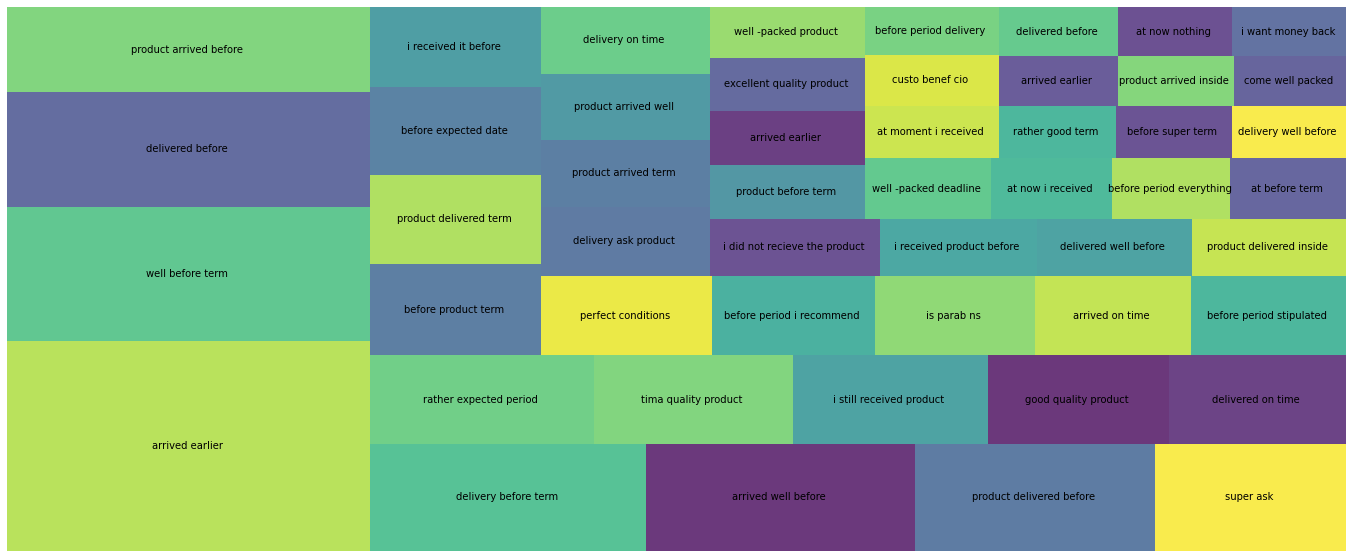

In [ ]:
fig, ax = plt.subplots(1, figsize = (24,10))

squarify.plot(sizes= important_trigrams['frequency'], 
              label= important_trigrams['english_translation'][:50], 
              alpha=.8)
plt.axis('off')
plt.show()

**ORDER DATASET: CHECKING 5 COMPONENTS AFFECTING DELIVERY TIME** (SLIDE 12)

In [ ]:
data = data[data['order_status'] == 'delivered']

In [ ]:
#Change data type to datetime
data['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'])
data['order_approved_at'] = pd.to_datetime(order['order_approved_at'])
data['order_delivered_carrier_date'] = pd.to_datetime(order['order_delivered_carrier_date'])
data['order_delivered_customer_date'] = pd.to_datetime(order['order_delivered_customer_date'])
data['order_estimated_delivery_date'] = pd.to_datetime(order['order_estimated_delivery_date'])

In [ ]:
#Calculate the time frame between stages
data['approve_day'] = data['order_approved_at'] - data['order_purchase_timestamp']
data['carrier_day'] = data['order_delivered_carrier_date'] - data['order_approved_at']
data['customer_day'] = data['order_delivered_customer_date'] - data['order_delivered_carrier_date'] 
data['estimated_day'] = data['order_estimated_delivery_date'] - data['order_delivered_customer_date'] 
data['estimated_gap'] = data['order_estimated_delivery_date'] - data['order_purchase_timestamp'] 

In [ ]:
#Change timeline to day
data['approve_day'] = data['approve_day'].dt.days
data['carrier_day'] = data['carrier_day'].dt.days
data['customer_day'] = data['customer_day'].dt.days
data['estimated_day'] = data['estimated_day'].dt.days
data['estimated_gap'] = data['estimated_gap'].dt.days

In [ ]:
data['year'] = data['order_purchase_timestamp'].astype(str)
data['year'] = data['year'].str.slice(0,7,1)

In [ ]:
approve_group = data.groupby('year')['approve_day'].mean().reset_index()
carrier_group = data.groupby('year')['carrier_day'].mean().reset_index()
customer_group = data.groupby('year')['customer_day'].mean().reset_index()
estimated_group = data.groupby('year')['estimated_day'].mean().reset_index()
gap_group = data.groupby('year')['estimated_gap'].mean().reset_index()
group = approve_group.merge(carrier_group, on = 'year').merge(customer_group, on = 'year').merge(estimated_group, on = 'year').merge(gap_group, on = 'year')
group
# Plot stacked columns in excel for better visualization 

,year,approve_day,carrier_day,customer_day,estimated_day,estimated_gap
0,2016-09,21.750000,31.500000,1.000000,-37.000000,32.750000
1,2016-10,1.181230,12.791822,5.547893,35.570881,54.844444
2,2016-12,0.000000,3.000000,1.000000,21.000000,26.000000
3,2017-01,0.329016,2.494595,8.774105,26.311295,39.206452
4,2017-02,0.298307,2.771429,9.027466,18.209114,31.617255
5,2017-03,0.179675,2.306954,9.435720,11.327909,24.605792
6,2017-04,0.400172,2.623138,10.767442,11.965116,27.054008
7,2017-05,0.262759,2.040564,7.866199,12.521472,23.970350
8,2017-06,0.246011,2.233766,8.466205,11.673920,23.730083
9,2017-07,0.252437,2.192227,8.051118,11.486688,22.994876


**SELLERS AND CUSTOMERS DISTRIBUTION**

In [ ]:
#Merge sellers and customers table to the big data table
data = data.merge(seller, on = 'seller_id')
data = data.merge(customer, on = 'customer_id')

In [ ]:
#Seller Geographic Distribution
data['seller_state'].value_counts()

SP    80749
MG     8792
PR     8755
RJ     4775
SC     4147
RS     2195
DF      920
BA      679
GO      527
PE      459
MA      400
ES      366
MT      146
CE       99
MS       59
RN       56
PB       39
RO       14
PI       11
SE       10
PA        8
AM        3
Name: seller_state, dtype: int64

In [ ]:
#Customer Geographic Distribution
data['customer_state'].value_counts()

SP    47821
RJ    14566
MG    13219
RS     6312
PR     5790
SC     4142
BA     3845
DF     2397
GO     2305
ES     2268
PE     1796
CE     1480
MT     1060
PA     1057
MS      837
MA      807
PB      605
RN      553
PI      541
AL      438
SE      382
TO      329
RO      274
AM      167
AC       92
AP       82
RR       44
Name: customer_state, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99163 entries, 0 to 99162
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99163 non-null  object 
 1   customer_unique_id             99163 non-null  object 
 2   zip_code_prefix                99163 non-null  int64  
 3   customer_city                  99163 non-null  object 
 4   customer_state                 99163 non-null  object 
 5   latitudes                      99163 non-null  float64
 6   longitudes                     99163 non-null  float64
 7   order_id                       99163 non-null  object 
 8   order_status                   99163 non-null  object 
 9   order_purchase_timestamp       99163 non-null  object 
 10  order_approved_at              99004 non-null  object 
 11  order_delivered_carrier_date   97387 non-null  object 
 12  order_delivered_customer_date  96212 non-null 

**CHECK OUT LATE DELIVERIES & SAME STATE & CROSS STATE**

In [ ]:
late = data[data['order_delivered_customer_date'] > data['order_estimated_delivery_date']]

In [ ]:
#Percentage of orders deliver Same State
same_state = data[data['customer_state'] == data['seller_state']]
round((same_state.shape[0] /data.shape[0]) * 100)

36

In [ ]:
#Percentage of orders deliver Cross State
cross_state = data[data['customer_state'] != data['seller_state']]
round((cross_state.shape[0] /data.shape[0]) * 100)

64

**OLIST WAREHOUSE RECOMMENDATION**

JUST IN CASE THE CODES BELOW DON"T SHOW UP, I HAVE MADE ANOTHER FILE JUST ABOUT THIS WAREHOUSE RECOMMENDATION HERE FOR PREFERENCE
https://colab.research.google.com/drive/1QARo2OkvN1obfM7er324yIbUMl06Gwmq?authuser=1#scrollTo=2kpMZIK0aa_8

In [ ]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opencage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import folium
from folium.plugins import FastMarkerCluster
import matplotlib.pyplot as plt
import scipy.spatial
from haversine import haversine

In [ ]:
def distance(p1,p2):
  return haversine(p1[1:],p2[1:])
def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append(np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,[0]])),axis=0))
  return results
def kmeans(data, k=None, centroids=None, steps=30):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
  elbow = []
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: (distance(u,v)**2))
    elbow.append(sqdists)
    #sse=np.sum((np.mean(elbow)-elbow)**2)
    # Index of the closest centroid to each data point.
    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)
    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  
  return clusters, centroids,elbow

In [ ]:
pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
customer = customer.rename(columns={'customer_zip_code_prefix': 'zip_code_prefix'})

In [ ]:
geo = geo_df.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

In [ ]:
geo = geo.rename(columns={'geolocation_zip_code_prefix': 'zip_code_prefix'})
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat  19015 non-null  float64
 2   geolocation_lng  19015 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 445.8 KB


In [ ]:
# geo_customer = pd.merge(geo, customer, on = 'customer_state', how = 'inner' )
data = customer.merge(geo, on = 'zip_code_prefix').merge(order, on = 'customer_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99163 entries, 0 to 99162
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99163 non-null  object 
 1   customer_unique_id             99163 non-null  object 
 2   zip_code_prefix                99163 non-null  int64  
 3   customer_city                  99163 non-null  object 
 4   customer_state                 99163 non-null  object 
 5   geolocation_lat                99163 non-null  float64
 6   geolocation_lng                99163 non-null  float64
 7   order_id                       99163 non-null  object 
 8   order_status                   99163 non-null  object 
 9   order_purchase_timestamp       99163 non-null  object 
 10  order_approved_at              99004 non-null  object 
 11  order_delivered_carrier_date   97387 non-null  object 
 12  order_delivered_customer_date  96212 non-null 

In [ ]:
data = data.rename(columns ={'geolocation_lat': 'latitudes', 'geolocation_lng':'longitudes'})

In [ ]:
lats=data['latitudes'].to_list()
lons=data['longitudes'].to_list()

In [ ]:
data['number'] = 1

In [ ]:
vals = data[['number','latitudes','longitudes']].values

sse=[]
for k in range(1,11):
  clusters,centroids,elbow=kmeans(vals[::],k)
  sqdist = np.sum((elbow-np.mean(elbow))**2)
  sse.append(sqdist)
sse=sorted(sse,reverse=True)

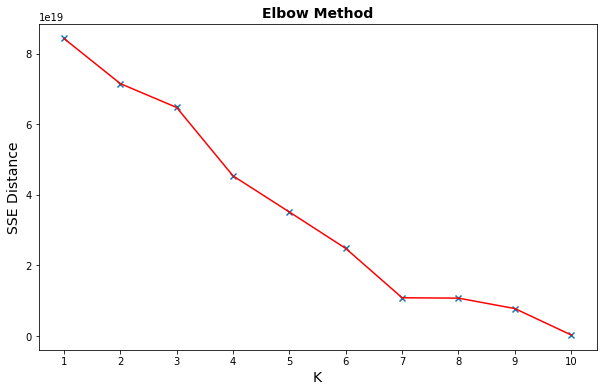

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(10,6))
x=list(range(1,11))
labels=x
plt.plot(x,sse,'r')
plt.scatter(x,sse,marker='x')
plt.xticks(x, labels)
plt.title('Elbow Method', size = 14, fontweight = 'bold')
plt.xlabel('K', size = 14)
plt.ylabel('SSE Distance', size = 14)
plt.show()
plt.savefig('elbow2.png', transparent=True)

In [ ]:
k = 4
random.seed(42)
#run it
clusters,centroids,elbow=kmeans(vals,k)
#output
data['c']=[int(c) for c in clusters]
lats = [centroids[i][1] for i in range(k)]
data['clat'] = data['c'].map(lambda x: lats[x])
longs = [centroids[i][2] for i in range(k)]
data['clong'] = data['c'].map(lambda x: longs[x])
#d['Count']= d.groupby('c')['Facility_Name'].nunique()
data.head()
data

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,latitudes,longitudes,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,number,c,clat,clong
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,3,-22.454178,-45.634530
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,-20.498489,-47.396929,95261f608a64bbbe760a212b4d48a4ee,delivered,2018-06-15 20:07:13,2018-06-15 20:41:11,2018-06-18 15:52:00,2018-06-21 12:18:32,2018-07-05 00:00:00,1,3,-22.454178,-45.634530
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,franca,SP,-20.498489,-47.396929,9444fa2ab50a3f5af63b48be297eda24,delivered,2017-09-09 15:40:00,2017-09-09 15:50:24,2017-09-11 13:43:41,2017-09-18 20:21:42,2017-10-02 00:00:00,1,3,-22.454178,-45.634530
3,702b62324327ccba20f1be3465426437,8b3d988f330c1d1c3332ccd440c147b7,14409,franca,SP,-20.498489,-47.396929,dceb8e88274c6f42a88a76ed979eb817,delivered,2018-03-26 12:04:55,2018-03-26 12:15:37,2018-03-27 00:54:33,2018-03-28 19:27:01,2018-04-12 00:00:00,1,3,-22.454178,-45.634530
4,bdf997bae7ca819b0415f5174d6b4302,866755e25db620f8d7e81b351a15bb2f,14409,franca,SP,-20.498489,-47.396929,6ee1cea1b2edcc713f83ebfbccbc57f9,delivered,2018-07-29 20:39:20,2018-07-29 20:55:21,2018-07-31 12:39:00,2018-08-03 16:48:40,2018-08-09 00:00:00,1,3,-22.454178,-45.634530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99158,0b7a30ba373aeb55cf28add5b5477956,8c8173e547e020f411aa55b2fceed861,87145,paicandu,PR,-23.501806,-52.150926,e12f5458c6b4f349a97fbf22e08d17ac,delivered,2017-08-01 12:57:02,2017-08-02 03:03:55,2017-08-02 17:47:19,2017-08-15 13:54:33,2017-08-23 00:00:00,1,2,-26.892205,-51.066685
99159,ff6b440b2465bfaef05c675efb48cd15,e38a27b979a552e019e297ecc22dc67b,98860,eugenio de castro,RS,-28.527590,-54.145960,82a11e82ea02c7e3381366e935c1126e,delivered,2018-05-23 09:07:46,2018-05-25 02:54:54,2018-05-25 12:11:00,2018-06-06 16:18:51,2018-06-07 00:00:00,1,2,-26.892205,-51.066685
99160,3f7029d9b98a47370cd5f3a97adcbccd,5894d202cc869b4ec460fce3c6ed8cb5,5538,sao paulo,SP,-23.588483,-46.737908,6e9f8d6156d8c37f0e0e6351908de639,delivered,2018-03-28 12:28:04,2018-03-28 12:47:35,2018-03-29 19:19:06,2018-04-10 13:40:54,2018-04-16 00:00:00,1,3,-22.454178,-45.634530
99161,d9110683c7a282144e9fc97660026a28,5cbfdb85ec130898108b32c50d619c39,74980,aparecida de goiania,GO,-16.822735,-49.248175,e65fa5f31ce4436d38bcf5e109fd43e4,delivered,2018-01-24 17:53:44,2018-01-24 18:12:41,2018-01-30 15:13:39,2018-02-20 17:48:37,2018-02-19 00:00:00,1,1,-12.880644,-50.635761


In [ ]:
c_lat=list(set(data['clat']))
c_long=list(set(data['clong']))
centroids=list(zip(c_lat,c_long))

In [ ]:
m2 = folium.Map(
    location=[33.798259,-84.327062],
    zoom_start=4.4)

for i in range(len(centroids)):
    folium.CircleMarker(centroids[i]).add_to(m2)
    
folium.LayerControl().add_to(m2)
m2

### Conclusions:
- Olist had a positive performance between 9/2016 - 9/2018 with 81% rating from 4-5 stars and 92% on-time delivery, 3-digit growth YOY in sellers, customers, and orders.

- However, only 3% of customers purchased 2nd time within 2 years, which accounted for 6% of total orders (pretty low for an ecom). Moreover, repeat customers tended to return for Vouchers and Long-term installment products.

- Out of 58% of reviews received, just a few were about good quality products, and most comments were about the late delivery process.

- Breaking down the delivery process, witnessed fluctuation between delivery elements, incredibly long tracked day from carriers to customers, and the estimated gap from Olist

- 80% of sellers were in SP, MG, PR, while 59% of customers were located in the same area

- Most late deliveries from carriers to customers were in North and North West Brazil, up to 84 days avg.

- Not an e-commerce itself but as a SAAS company, Olist was unable to control the delivery process, especially from Sellers to Carriers.


### Recommendations:

- Olist should have its own shipping company or partner with delivery companies

- Arranging warehouses in 4 optimal locations will help to shorten delivery distances. Those 4 places are in Sao Paulo, Rio De Janero, Salvado, and Para.

- Give out a timeframe for sellers to follow and manage their orders (1 week for same-state delivery, 2 weeks for cross-state)

- Review and shorten the estimated delivery gap, currently nearly double the actual process for both same-state and cross state